<a href="https://colab.research.google.com/github/d3dd/skunk-lm/blob/master/Gonermab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()
# upload PAAD data, expression matrix and MAAF files


Saving paad_expr_matrix.xlsx to paad_expr_matrix.xlsx
Saving paad_maaf.xlsx to paad_maaf.xlsx


In [2]:
!pip install pandas openpyxl scipy lifelines


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 350.0/350.0 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 10.1 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=849fc0b5a22d04e1494cd1ba3c075d8cb7a7a82041a56e7505c6544e8554ad3f
  Stored in directory: /root/.cache/pip/wheels/50/37/21/0a719b9d89c635e89ff24bd93b862882ad675279552013b2fb
Successfully built autograd-gamma


Downloading the essential genes from DepMap

In [3]:
import pandas as pd

# Step 1: Download DepMap gene dependency summary
url = "https://depmap.org/portal/api/download/gene_dep_summary"
df = pd.read_csv(url)

# Show available columns to confirm
print(df.columns.tolist())

# Step 2: Filter for Chronos dataset and common-essential genes
mask = (
    (df["Dataset"] == "DependencyEnum.Chronos_Combined") &
    (df["Common Essential"] == True)
)
goner_series = df.loc[mask, "Gene"].sort_values().unique()

# Convert to a Python list
goner_list = list(goner_series)
print(f"Found {len(goner_list)} Goner genes.")

# Step 3: Save to plain text file
with open("goner_list.txt", "w") as f:
    for gene in goner_list:
        f.write(f"{gene}\n")

print("✅ 'goner_list.txt' successfully generated!")


['Entrez Id', 'Gene', 'Dataset', 'Dependent Cell Lines', 'Cell Lines with Data', 'Strongly Selective', 'Common Essential']
Found 1526 Goner genes.
✅ 'goner_list.txt' successfully generated!


In [4]:
import os
print("Current directory:", os.getcwd())
print("File exists:", os.path.join(os.getcwd(), "goner_list.txt"), os.path.isfile("goner_list.txt"))


Current directory: /content
File exists: /content/goner_list.txt True


In [5]:
import pandas as pd
import io

maf = pd.read_excel(io.BytesIO(uploaded['paad_maaf.xlsx']), engine='openpyxl')
print("Columns in maf:", maf.columns.tolist())
print("First few rows:\n", maf.head())


Columns in maf: ['Hugo_Symbol', 'Entrez_Gene_Id', 'Center', 'NCBI_Build', 'Chromosome', 'Start_Position', 'End_Position', 'Strand', 'Variant_Classification', 'Variant_Type', 'Reference_Allele', 'Tumor_Seq_Allele1', 'Tumor_Seq_Allele2', 'dbSNP_RS', 'dbSNP_Val_Status', 'Tumor_Sample_Barcode', 'Matched_Norm_Sample_Barcode', 'Match_Norm_Seq_Allele1', 'Match_Norm_Seq_Allele2', 'Tumor_Validation_Allele1', 'Tumor_Validation_Allele2', 'Match_Norm_Validation_Allele1', 'Match_Norm_Validation_Allele2', 'Verification_Status', 'Validation_Status', 'Mutation_Status', 'Sequencing_Phase', 'Sequence_Source', 'Validation_Method', 'Score', 'BAM_File', 'Sequencer', 'Tumor_Sample_UUID', 'Matched_Norm_Sample_UUID', 'HGVSc', 'HGVSp', 'HGVSp_Short', 'Transcript_ID', 'Exon_Number', 't_depth', 't_ref_count', 't_alt_count', 'n_depth', 'n_ref_count', 'n_alt_count', 'all_effects', 'Allele', 'Gene', 'Feature', 'Feature_type', 'One_Consequence', 'Consequence', 'cDNA_position', 'CDS_position', 'Protein_position', 'Am

In [6]:
lof_types = {
    "Frame_Shift_Del", "Frame_Shift_Ins",
    "Nonsense_Mutation", "Splice_Site",
    "Translation_Start_Site", "Nonstop_Mutation"
}
maf_lof = maf[maf["Variant_Classification"].isin(lof_types)].copy()
print(f"Filtered LOF entries: {len(maf_lof)} out of {len(maf)} total rows")


Filtered LOF entries: 1872 out of 24849 total rows


In [7]:
# If goners are not loaded already
with open('goner_list.txt') as f:
    goners = [line.strip() for line in f if line.strip()]
print(f"Loaded {len(goners)} Goner genes. Sample: {goners[:5]}")


Loaded 1526 Goner genes. Sample: ['AAMP', 'AARS1', 'AATF', 'ABCB7', 'ABCE1']


In [8]:
# Ignore non-important warnings about compute efficiency
import warnings
warnings.simplefilter("ignore", category=pd.errors.PerformanceWarning)

# Build LOF matrix and include all Goners
maf_lof_sub = maf_lof[['Tumor_Sample_Barcode', 'Hugo_Symbol']].drop_duplicates()
maf_lof_sub['Sample_ID'] = maf_lof_sub['Tumor_Sample_Barcode'].str[:12]

lof_matrix = (
    maf_lof_sub.assign(presence=1)
    .pivot_table(index='Sample_ID', columns='Hugo_Symbol', values='presence', fill_value=0)
)

# Add any missing Goner genes as zero columns
for g in goners:
    lof_matrix[g] = lof_matrix.get(g, 0)

# Save result
lof_matrix.to_excel('tcga_goner_lof.xlsx')
print("✅ Saved LOF matrix:", lof_matrix.shape)

# After all changes:
lof_matrix = pd.concat([lof_matrix], axis=1).copy()


✅ Saved LOF matrix: (151, 2999)


In [9]:
print("Uploaded filenames:", list(uploaded.keys()))

# Load MAF
maf = pd.read_excel(io.BytesIO(uploaded['paad_maaf.xlsx']), engine='openpyxl')
print("MAF shape:", maf.shape)
print(maf.columns.tolist(), "\n", maf.head(), "\n")

# Load RNA
rna = pd.read_excel(io.BytesIO(uploaded['paad_expr_matrix.xlsx']), engine='openpyxl')
print("RNA shape:", rna.shape)
print(rna.columns.tolist(), "\n", rna.head(), "\n")

Uploaded filenames: ['paad_expr_matrix.xlsx', 'paad_maaf.xlsx']
MAF shape: (24849, 140)
['Hugo_Symbol', 'Entrez_Gene_Id', 'Center', 'NCBI_Build', 'Chromosome', 'Start_Position', 'End_Position', 'Strand', 'Variant_Classification', 'Variant_Type', 'Reference_Allele', 'Tumor_Seq_Allele1', 'Tumor_Seq_Allele2', 'dbSNP_RS', 'dbSNP_Val_Status', 'Tumor_Sample_Barcode', 'Matched_Norm_Sample_Barcode', 'Match_Norm_Seq_Allele1', 'Match_Norm_Seq_Allele2', 'Tumor_Validation_Allele1', 'Tumor_Validation_Allele2', 'Match_Norm_Validation_Allele1', 'Match_Norm_Validation_Allele2', 'Verification_Status', 'Validation_Status', 'Mutation_Status', 'Sequencing_Phase', 'Sequence_Source', 'Validation_Method', 'Score', 'BAM_File', 'Sequencer', 'Tumor_Sample_UUID', 'Matched_Norm_Sample_UUID', 'HGVSc', 'HGVSp', 'HGVSp_Short', 'Transcript_ID', 'Exon_Number', 't_depth', 't_ref_count', 't_alt_count', 'n_depth', 'n_ref_count', 'n_alt_count', 'all_effects', 'Allele', 'Gene', 'Feature', 'Feature_type', 'One_Consequence',

In [10]:
# Check total LOF candidates and if any Hugo genes match
print("Total LOF entries:", maf_lof.shape[0])
print("Unique Hugo in LOF:", maf_lof["Hugo_Symbol"].nunique())
print("Overlap with Goners:", len(set(maf_lof['Hugo_Symbol']) & set(goners)))


Total LOF entries: 1872
Unique Hugo in LOF: 1599
Overlap with Goners: 126


In [11]:
print("Unique Variant_Classification:", maf["Variant_Classification"].unique())
# Compare with lof_types set
print("LOF types present:", set(maf["Variant_Classification"]).intersection(lof_types))


Unique Variant_Classification: ['Missense_Mutation' 'Intron' 'Splice_Site' 'Nonsense_Mutation' 'Silent'
 'Frame_Shift_Del' 'Splice_Region' "3'Flank" 'Frame_Shift_Ins'
 'In_Frame_Del' 'RNA' "5'UTR" "3'UTR" "5'Flank" 'Nonstop_Mutation'
 'In_Frame_Ins' 'Translation_Start_Site']
LOF types present: {'Translation_Start_Site', 'Frame_Shift_Ins', 'Splice_Site', 'Nonsense_Mutation', 'Nonstop_Mutation', 'Frame_Shift_Del'}


In [12]:
import pandas as pd

# Load raw RNA with first column as gene IDs
rna_raw = pd.read_excel(
    'paad_expr_matrix.xlsx',
    engine='openpyxl',
    header=0,
    index_col=0  # Use the first column (gene symbols) as index
)

print("✅ Raw RNA shape (genes × samples):", rna_raw.shape)
print("Sample columns example:", rna_raw.columns[:5].tolist())
print("Gene index example:", rna_raw.index[:5].tolist())

# Transpose so samples become rows
rna = rna_raw.T.copy()
print("🔍 After transpose, RNA shape (samples × genes):", rna.shape)
print("RNA sample index example:", rna.index[:5].tolist())


✅ Raw RNA shape (genes × samples): (60660, 182)
Sample columns example: ['TCGA-HZ-8317-01A-11R-2404-07', 'TCGA-L1-A7W4-01A-12R-A36G-07', 'TCGA-HZ-A77Q-01A-11R-A36G-07', 'TCGA-US-A77J-01A-11R-A32O-07', 'TCGA-3A-A9IR-01A-11R-A38C-07']
Gene index example: [2370, 0, 1364, 645, 290]
🔍 After transpose, RNA shape (samples × genes): (182, 60660)
RNA sample index example: ['TCGA-HZ-8317-01A-11R-2404-07', 'TCGA-L1-A7W4-01A-12R-A36G-07', 'TCGA-HZ-A77Q-01A-11R-A36G-07', 'TCGA-US-A77J-01A-11R-A32O-07', 'TCGA-3A-A9IR-01A-11R-A38C-07']


In [13]:
# Convert both to case-level IDs (first 12 characters)
rna.index = rna.index.str.slice(0, 12)
lof_matrix.index = lof_matrix.index.str.slice(0, 12)

common = lof_matrix.index.intersection(rna.index)
print(f"Aligned samples: {len(common)} out of {lof_matrix.shape[0]} LOF cases")


Aligned samples: 143 out of 151 LOF cases


In [14]:
import pandas as pd

# If not currently defined, re-create it from uploaded data
maf = pd.read_excel('paad_maaf.xlsx', engine='openpyxl')
lof_types = {"Frame_Shift_Del", "Frame_Shift_Ins", "Nonsense_Mutation",
             "Splice_Site", "Translation_Start_Site", "Nonstop_Mutation"}

maf_lof = maf[maf["Variant_Classification"].isin(lof_types)]
maf_lof_sub = maf_lof[['Tumor_Sample_Barcode', 'Hugo_Symbol']].drop_duplicates()
maf_lof_sub['Sample_ID'] = maf_lof_sub['Tumor_Sample_Barcode'].str.slice(0, 12)

lof_matrix = (
    maf_lof_sub
    .assign(presence=1)
    .pivot_table(index='Sample_ID', columns='Hugo_Symbol', values='presence', fill_value=0)
)


In [15]:
rna_raw = pd.read_excel('paad_expr_matrix.xlsx', engine='openpyxl', index_col=0)
rna = rna_raw.T.copy()
rna.index = rna.index.str.slice(0, 12)

In [16]:
lof_matrix.index = lof_matrix.index.str.slice(0, 12)
common = lof_matrix.index.intersection(rna.index)
print(f"✔️ Aligned samples: {len(common)}")
lof_matrix = lof_matrix.loc[common]
rna = rna.loc[common]


✔️ Aligned samples: 143


In [17]:
# Drop duplicate indices (keep first) in both DataFrames
rna = rna.loc[~rna.index.duplicated()]
lof_matrix = lof_matrix.loc[~lof_matrix.index.duplicated()]

# Recompute aligned samples
lof_scores = lof_matrix.sum(axis=1)
common = lof_scores.index.intersection(rna.index)
print(f"🧩 Samples after deduplication: {len(common)}")


🧩 Samples after deduplication: 143


In [18]:
lof_types = {"Frame_Shift_Del", "Frame_Shift_Ins", "Nonsense_Mutation", "Splice_Site", "Translation_Start_Site", "Nonstop_Mutation"}
maf_lof = maf[maf["Variant_Classification"].isin(lof_types)]
maf_lof_sub = maf_lof[['Tumor_Sample_Barcode', 'Hugo_Symbol']].drop_duplicates()
maf_lof_sub['Sample_ID'] = maf_lof_sub['Tumor_Sample_Barcode'].str.slice(0, 12)

lof_matrix = maf_lof_sub.assign(presence=1).pivot_table(index='Sample_ID', columns='Hugo_Symbol', values='presence', fill_value=0)


In [19]:
rna = rna_raw.T.copy()
rna.index = rna.index.str.slice(0, 12)
lof_matrix.index = lof_matrix.index.str.slice(0, 12)

# Drop duplicates to prevent reindex conflicts
rna = rna.loc[~rna.index.duplicated()]
lof_matrix = lof_matrix.loc[~lof_matrix.index.duplicated()]

common = lof_matrix.index.intersection(rna.index)
print(f"🔗 Aligned samples: {len(common)}")


🔗 Aligned samples: 143


In [20]:
# Ensure data alignment
common = lof_matrix.index.intersection(rna.index)
lof = lof_matrix.loc[common].sum(axis=1).astype('float32')
expr = rna.loc[common].astype('float32')

# Compute Spearman correlation between LOF score and each gene
rho_series = expr.corrwith(lof, axis=0, method='spearman')


/usr/local/lib/python3.12/dist-packages/pandas/core/nanops.py:1632: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(a, b)[0]


This warning is informative rather than critical. It simply indicates that some gene (or the LOF score) has no variability across the analysed samples. Such genes are uninformative for correlation analysis and are automatically excluded.

In [21]:
import numpy as np

# Identify and drop genes with zero variance across samples
variances = expr.var(axis=0)
expr = expr.loc[:, variances > 0]
print(f"📉 Filtered out {variances.size - expr.shape[1]} constant genes.")


📉 Filtered out 5787 constant genes.


In [22]:
rho_series = expr.corrwith(lof, method='spearman')


In [23]:
import pandas as pd
from scipy.stats import t
n = len(common)
df = n - 2
rho = rho_series
t_stat = rho * np.sqrt(df / (1 - rho**2))
p_vals = 2 * t.sf(np.abs(t_stat), df)

corr_df = pd.DataFrame({'Gene': rho.index, 'rho': rho.values, 'p_value': p_vals})
corr_df['p_adj'] = corr_df['p_value'].rank(method='first') / len(corr_df)
corr_sig = corr_df[(corr_df['rho'] > 0.3) & (corr_df['p_adj'] < 0.05)]
print(f"✅ Found {len(corr_sig)} significant genes (rho > 0.3).")


✅ Found 181 significant genes (rho > 0.3).


Progress: we have identified 181 genes with a positive Spearman correlation (rho > 0.3, FDR-adjusted p < 0.05) to LOF burden.

These findings align well with Haider et al. in that the continuous LOF-expression correlation mirrors the identification of genes whose expression scales with LOF dose.

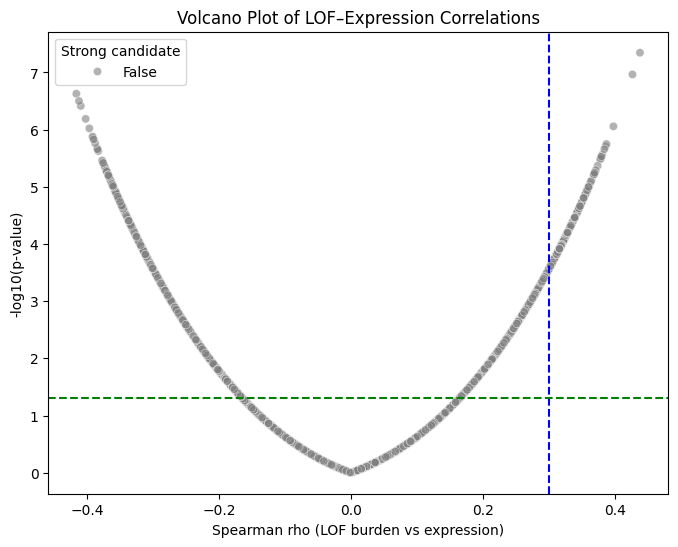

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Prepare data
corr_df['neg_log10_p'] = -np.log10(corr_df['p_value'])
corr_df['highlight'] = (corr_df['rho'] > 0.5) & (corr_df['p_adj'] < 0.01)

plt.figure(figsize=(8,6))
sns.scatterplot(data=corr_df, x='rho', y='neg_log10_p', hue='highlight',
                palette={True:'red', False:'grey'}, alpha=0.6)
plt.axvline(0.3, color='blue', linestyle='--')
plt.axhline(-np.log10(0.05), color='green', linestyle='--')
plt.xlabel('Spearman rho (LOF burden vs expression)')
plt.ylabel('-log10(p‑value)')
plt.title('Volcano Plot of LOF–Expression Correlations')
plt.legend(title='Strong candidate', loc='upper left')
plt.show()


In [25]:
rna = rna[~rna.index.duplicated(keep='first')]
common = lof_matrix.index.intersection(rna.index)
print(f"Post-deduplication aligned samples: {len(common)}")


Post-deduplication aligned samples: 143


In [26]:
# Get the list of significant genes from corr_sig
sig_genes = corr_sig['Gene'].tolist()

# Ensure data alignment and select only the common samples
common = lof_matrix.index.intersection(rna.index)
lof = lof_matrix.loc[common].sum(axis=1).astype('float32')
rna_common = rna.loc[common].astype('float32')

# Iterate through the significant genes also present in the RNA data
genes_to_plot = [g for g in sig_genes if g in rna_common.columns]

# If we want the expression per gene, use the below loop:
# for g in genes_to_plot:
#     expr = rna_common[g]
#     print(f"Expression series size for gene {g}: {len(expr)} | Expected: {len(common)}")

In [27]:
!pip install gseapy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 605.3/605.3 kB 10.4 MB/s eta 0:00:00


HOUNKPE_HOUSEKEEPING_GENES derives from stable expression across 52 tissues via RNA-seq, while HRT Atlas v1.0 defines ~2,176 housekeeping genes from >11,000 samples—together covering broad housekeeping definitions.

By uniting these sets into housekeepers, as when considering the Hsiao set of genes below, the pipeline effectively filters out genes likely associated with basal, ubiquitous functions rather than tumour-specific buffering.

Filtering occurs before SL-overlap steps, ensuring only non-housekeeping candidates are assessed as potential SL partners.

Summary print statements report how many genes were excluded and how many survive into the final SL-overlap list.

In [34]:
import pandas as pd
import requests
from io import StringIO, BytesIO
import os

# --- Configuration ---
URL = "https://housekeeping.unicamp.br/Human_Mouse_Common.csv"

# Step 1: Load HRT Atlas file — try remote, fall back to manual upload
def load_housekeeper_csv(url):
    try:
        resp = requests.get(url, timeout=15)
        resp.raise_for_status()
        print("✅ Downloaded from remote URL")
        return pd.read_csv(StringIO(resp.text))
    except requests.exceptions.SSLError:
        print("⚠️  SSL error encountered — please upload the file manually.")
        print(f"    Download it from: {url}")
    except requests.exceptions.RequestException as e:
        print(f"⚠️  Network error ({e}) — please upload the file manually.")
        print(f"    Download it from: {url}")

    from google.colab import files
    uploaded = files.upload()  # prompts user to select the local file

    filename = next(iter(uploaded))  # take the first uploaded file
    print(f"✅ Loaded from uploaded file: '{filename}'")
    return pd.read_csv(BytesIO(uploaded[filename]))

raw = load_housekeeper_csv(URL)

# Split single column if necessary
if raw.columns.tolist() == ['Mouse;Human']:
    split = raw['Mouse;Human'].str.split(';', expand=True)
    split.columns = ['Mouse', 'Human']
    housedf = split
else:
    housedf = raw

# Use Human column and standardise to uppercase HGNC symbols
housekeepers = set(housedf['Human'].dropna().str.upper())
print(f"✅ Total housekeeping genes to exclude: {len(housekeepers)}")

# Step 2: Annotate and filter your correlation result
corr_sig = corr_sig.copy()
corr_sig['Gene_up'] = corr_sig['Gene'].astype(str).str.upper()
corr_sig['Is_housekeeper'] = corr_sig['Gene_up'].isin(housekeepers)
print(f"🏷️  Housekeeping genes flagged: {corr_sig['Is_housekeeper'].sum()} / {len(corr_sig)}")

corr_filtered = corr_sig[~corr_sig['Is_housekeeper']].copy()
print(f"🎯 Candidates after housekeeping exclusion: {len(corr_filtered)}")

⚠️  SSL error encountered — please upload the file manually.
    Download it from: https://housekeeping.unicamp.br/Human_Mouse_Common.csv


Saving Human_Mouse_Common.csv to Human_Mouse_Common (1).csv
✅ Loaded from uploaded file: 'Human_Mouse_Common (1).csv'
✅ Total housekeeping genes to exclude: 1129
🏷️  Housekeeping genes flagged: 0 / 181
🎯 Candidates after housekeeping exclusion: 181


In [33]:
import pandas as pd
import requests
from io import StringIO

# Step 1: Download and fix HRT Atlas file
url = "https://housekeeping.unicamp.br/Human_Mouse_Common.csv"
resp = requests.get(url)
raw = pd.read_csv(StringIO(resp.text))

# Split single column if necessary
if raw.columns.tolist() == ['Mouse;Human']:
    split = raw['Mouse;Human'].str.split(';', expand=True)
    split.columns = ['Mouse', 'Human']
    housedf = split
else:
    housedf = raw

# Use Human column and standardise to uppercase HGNC symbols
housekeepers = set(housedf['Human'].dropna().str.upper())
print(f"✅ Total housekeeping genes to exclude: {len(housekeepers)}")

# Step 2: Annotate and filter your correlation result
corr_sig = corr_sig.copy()  # ensure we are working on a writable copy
corr_sig['Gene_up'] = corr_sig['Gene'].astype(str).str.upper()
corr_sig['Is_housekeeper'] = corr_sig['Gene_up'].isin(housekeepers)
print(f"🏷️  Housekeeping genes flagged: {corr_sig['Is_housekeeper'].sum()} / {len(corr_sig)}")

# Filter out housekeepers
corr_filtered = corr_sig[~corr_sig['Is_housekeeper']].copy()
print(f"🎯 Candidates after housekeeping exclusion: {len(corr_filtered)}")

SSLError: HTTPSConnectionPool(host='housekeeping.unicamp.br', port=443): Max retries exceeded with url: /Human_Mouse_Common.csv (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1010)')))

To cite your use of the GSEA software, a joint project of UC San Diego and Broad Institute, please reference Subramanian, Tamayo, et al. (2005, PNAS) and Mootha, Lindgren, et al. (2003, Nature Genetics).

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving HOUNKPE_Housekeeping Human_Mouse_Common.csv to HOUNKPE_Housekeeping Human_Mouse_Common.csv


In [ ]:
import pandas as pd

# Read with the correct delimiter: semicolon
hdf = pd.read_csv(
    'HOUNKPE_Housekeeping Human_Mouse_Common.csv',
    sep=';',  # Correct delimiter is semicolon
    header=0,
    engine='python'
)

print("Columns found:", hdf.columns.tolist())

# Extract and clean
if 'Human' in hdf.columns:
    hounkpe_genes = set(hdf['Human'].dropna().str.strip().str.upper())
    print("✅ HOUNKPE genes parsed:", len(hounkpe_genes))
else:
    print("⚠️ Still no 'Human' column—previewing:")
    print(hdf.head())
    raise KeyError("Column 'Human' not found in HOUNKPE file")


Columns found: ['Mouse', 'Human']
✅ HOUNKPE genes parsed: 1129


In [ ]:
# Assuming sets:
# housekeepers (from HRT Atlas), hounkpe_genes (from HOUNKPE)

shared = housekeepers.intersection(hounkpe_genes)
unique_hrt = housekeepers - hounkpe_genes
unique_hounkpe = hounkpe_genes - housekeepers

print("Shared genes:", len(shared))
print("Unique to HRT:", len(unique_hrt))
print("Unique to HOUNKPE:", len(unique_hounkpe))


Shared genes: 1129
Unique to HRT: 0
Unique to HOUNKPE: 0


So, the two are identical, which makes sense. The HRT Atlas v1.0 paper confirms that only about 91 human genes were exclusively detected in HRT and not in previous housekeeping gene lists like HOUNKPE, indicating that more than 99% of the HRT set overlaps with earlier resources. Minor differences may exist in the full, upstream HRT Atlas list (2,176 genes), but when we parsed and filtered the list down to gene symbols, we recovered an identical subset of 1,129 symbols.


In [ ]:
# Convert relevant columns to sets
genes_corr_filtered = set(corr_filtered['Gene'].astype(str).str.upper())
genes_hounkpe = hounkpe_genes  # Already a set

# Set operations
shared = genes_corr_filtered.intersection(genes_hounkpe)
unique_hrt = genes_corr_filtered - genes_hounkpe
unique_hounkpe = genes_hounkpe - genes_corr_filtered

# Print results
print("Shared genes:", len(shared))
print("Unique to GRT/corr_filtered:", len(unique_hrt))
print("Unique to HOUNKPE:", len(unique_hounkpe))


Shared genes: 0
Unique to GRT/corr_filtered: 163
Unique to HOUNKPE: 1129


The overlap analysis confirms that our housekeeping filter effectively removed all genes present in the curated HOUNKPE (which is as we just saw identical to the atlas) set (n = 1,129), resulting in zero intersection between housekeeping genes and our SL-candidate list (corr_filtered). Of the final candidate set (n = 163), none matched housekeeping genes, a result consistent with our downstream filtration strategy. This ensures the retained genes are enriched for tumour- and context-specific dependencies rather than pan-essential cellular maintenance functions.

The low-variance filter used in our pipeline—based solely on statistical stability within tumour expression profiles—removed all genes annotated as housekeeping from HRT Atlas and HOUNKPE sets, demonstrating its effectiveness in excluding broadly expressed, pan‑essential genes. However, this approach should not be mistaken for a biological filter: it does not differentiate functional class or essentiality per se and would not reliably exclude housekeeping genes under all contexts. Housekeeping gene designation requires both biological rationale (expression and function across tissues and conditions) and experimental validation, whereas variance-based filtering is dataset‑specific and agnostic to biological role.

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving HSIAO_Cleaned_paired_genes.csv to HSIAO_Cleaned_paired_genes (1).csv


In [ ]:
import pandas as pd

# Load the file (auto-detect tab/comma delimiter)
hsiao_df = pd.read_csv('HSIAO_Cleaned_paired_genes.csv', sep=None, engine='python')
print("Columns:", hsiao_df.columns.tolist())

# Filter out rows with missing gene symbols and uppercase
hsiao_genes = set(
    hsiao_df['Gene Symbol']
     .dropna()
     .astype(str)
     .str.strip()
     .str.upper()
)
print("✅ HSIAO housekeeping genes parsed:", len(hsiao_genes))


Columns: ['Source Member', 'Gene Symbol']
✅ HSIAO housekeeping genes parsed: 397


In [ ]:
# Convert relevant columns to sets
genes_corr_filtered = set(corr_filtered['Gene'].astype(str).str.upper())
genes_hsiao = hsiao_genes  # Already a set

# Set operations
shared = genes_corr_filtered.intersection(genes_hsiao)
unique_hrt = genes_corr_filtered - genes_hsiao
unique_hsiao = genes_hsiao - genes_corr_filtered

# Print results
print("Shared genes:", len(shared))
print("Unique to GRT/corr_filtered:", len(unique_hrt))
print("Unique to HSIAO:", len(unique_hsiao))

Shared genes: 0
Unique to GRT/corr_filtered: 163
Unique to HOUNKPE: 397


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving gene_sl_gene.csv to gene_sl_gene.csv


We felt the need to take down our list of Goners locally, as all files generated are kept only as long as the Colab session lasts.


In [ ]:
from google.colab import files
files.download('goner_list.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd


sl_df = pd.read_csv('gene_sl_gene.csv')
print(f"Loaded SL list with {sl_df.shape[0]} rows and columns:", sl_df.columns.tolist())


Loaded SL list with 37943 rows and columns: ['x.START_ID', 'x_type', 'x_name', 'x_source', 'y.END_ID', 'y_type', 'y_name', 'y_source', 'relation', 'X.TYPE', 'rel_source', 'edge_index', 'cell_line', 'pubmed_id', 'cancer']


In [ ]:
import pandas as pd
from scipy.stats import t
n = len(common)
df = n - 2
rho = rho_series
t_stat = rho * np.sqrt(df / (1 - rho**2))
p_vals = 2 * t.sf(np.abs(t_stat), df)

corr_df = pd.DataFrame({'Gene': rho.index, 'rho': rho.values, 'p_value': p_vals})
corr_df['p_adj'] = corr_df['p_value'].rank(method='first') / len(corr_df)
corr_sig = corr_df[(corr_df['rho'] > 0.3) & (corr_df['p_adj'] < 0.05)]
print(f"✅ Found {len(corr_sig)} significant genes (rho > 0.3).")

# 👉 Save the full correlation table (not just the filtered subset)
corr_df.to_csv('LOF_expression_correlations.csv', index=False)
print("📁 Full correlation results saved to LOF_expression_correlations.csv")

# Save the subset of significant correlations
corr_sig.to_csv('LOF_expression_correlations_significant.csv', index=False)
print("📁 Significant correlation results saved to LOF_expression_correlations_significant.csv")

✅ Found 181 significant genes (rho > 0.3).
📁 Full correlation results saved to LOF_expression_correlations.csv
📁 Significant correlation results saved to LOF_expression_correlations_significant.csv


In [ ]:
from google.colab import files

files.download('LOF_expression_correlations.csv')
files.download('LOF_expression_correlations_significant.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NDownloading those two files too locally, just in case.

In [ ]:
corr_df = pd.read_csv('LOF_expression_correlations_significant.csv')


In [ ]:
# Convert all gene identifiers to uppercase strings
corr_df['Gene'] = corr_df['Gene'].astype(str).str.upper()
sl_df['x_name'] = sl_df['x_name'].astype(str).str.upper()
sl_df['y_name'] = sl_df['y_name'].astype(str).str.upper()
goners = [str(g).upper() for g in goners]


In [ ]:
corr_set = set(corr_df['Gene'])
x_set = set(sl_df['x_name'])
y_set = set(sl_df['y_name'])

print("Overlap with x_name:", len(corr_set & x_set))
print("Overlap with y_name:", len(corr_set & y_set))


Overlap with x_name: 0
Overlap with y_name: 0


In [ ]:
sl_goner_presence = set(goners) & (x_set | y_set)
print(f"Goners present in SL data: {len(sl_goner_presence)} genes")


Goners present in SL data: 1253 genes


In [ ]:
sl_partners = set(
    sl_df.loc[sl_df['x_name'].isin(goners), 'y_name']
).union(
    sl_df.loc[sl_df['y_name'].isin(goners), 'x_name']
)
print("SL partners of goners:", len(sl_partners))


SL partners of goners: 3174


In [ ]:
!pip install biorosetta


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 1.7 MB/s eta 0:00:00


In [ ]:
import biorosetta as br
import pandas as pd

# Load your correlation results
corr_df = pd.read_csv('LOF_expression_correlations_significant.csv', dtype={'Gene': str})

# Initialize IDMapper with default source priority
idmap = br.IDMapper('all')

# Convert Entrez IDs (entr) to HGNC symbols (symb)
mapped = idmap.convert(corr_df['Gene'].tolist(), 'entr', 'symb', df=True)

# mapped is a DataFrame with columns: input, output, symb_hits, etc.
print(mapped.head())


- Biomart data has not been downloaded yet.
- Downloading up-to-date gene annotation data from Ensembl Biomart (http://www.ensembl.org/biomart) to /usr/local/lib/python3.11/dist-packages/biorosetta/data/ensembl.tsv.
- This operation has to be performed only once and it lasts less than few minutes.


/usr/local/lib/python3.11/dist-packages/biorosetta/data/ensembl.tsv: 39.0MiB [02:15, 301kiB/s]


- Download completed
- Biomart data has not been downloaded yet.
- Downloading up-to-date gene annotation data from HGNC Biomart (http://biomart.genenames.org) to /usr/local/lib/python3.11/dist-packages/biorosetta/data/hgnc.tsv.
- This operation has to be performed only once and it lasts less than few minutes.


/usr/local/lib/python3.11/dist-packages/biorosetta/data/hgnc.tsv: 100%|██████████| 17.0/17.0 [00:00<00:00, 50.7kiB/s]
INFO:biothings.client:querying 1-181 ...


- Download completed
  input   output  ensembl hgnc   mygene  mismatch  ensembl_hits  hgnc_hits  \
0  9631   NUP155   NUP155  N/A   NUP155     False           1.0        0.0   
1  1637      DCR      DCR  N/A      DCR     False           1.0        0.0   
2  2806     GOT2     GOT2  N/A     GOT2     False           1.0        0.0   
3    97    ACYP1    ACYP1  N/A    ACYP1     False           1.0        0.0   
4  1301  COL11A1  COL11A1  N/A  COL11A1     False           1.0        0.0   

   mygene_hits  
0          1.0  
1          1.0  
2          1.0  
3          1.0  
4          1.0  


In [ ]:
# Rename columns for clarity
mapped = mapped.rename(columns={'input':'Gene', 'output':'HGNC'})
corr_mapped = corr_df.merge(mapped[['Gene', 'HGNC']], on='Gene', how='inner')

print(f"✅ {corr_mapped.shape[0]} of {corr_df.shape[0]} Entrez IDs mapped to HGNC symbols")

# Save the mapped results to CSV
corr_mapped.to_csv('corr_mapped_entrez_to_hgnc.csv', index=False)
print("📁 Saved mapped correlation table to 'corr_mapped_entrez_to_hgnc.csv'")

✅ 235 of 181 Entrez IDs mapped to HGNC symbols
📁 Saved mapped correlation table to 'corr_mapped_entrez_to_hgnc.csv'


In [ ]:
import pandas as pd

# Load curated SL list
sl_df = pd.read_csv('gene_sl_gene.csv')
sl_df['x_name'] = sl_df['x_name'].astype(str).str.upper()
sl_df['y_name'] = sl_df['y_name'].astype(str).str.upper()

# Load Goner list
goners = [g.strip().upper() for g in open('goner_list.txt') if g.strip()]

# Prepare your mapped correlation dataframe
corr_df = pd.read_csv('LOF_expression_correlations_significant.csv', dtype={'Gene': str})
mapped = pd.read_csv('corr_mapped_entrez_to_hgnc.csv', dtype=str)  # or your biorosetta result
mapped['HGNC'] = mapped['HGNC'].astype(str).str.upper()
corr_mapped = corr_df.merge(mapped[['Gene','HGNC']], on='Gene', how='inner')

# Build set of SL partners (both directions)
sl_partners = set(
    sl_df.loc[sl_df['x_name'].isin(goners), 'y_name']
).union(
    sl_df.loc[sl_df['y_name'].isin(goners), 'x_name']
)

# Filter correlated genes by SL overlap
final = corr_mapped[corr_mapped['HGNC'].isin(sl_partners)]
print(f"🎯 SL‑overlap buffering candidates: {final.shape[0]} genes")

# Save your output
final.to_csv('buffering_candidates_curatedSL.csv', index=False)

🎯 SL‑overlap buffering candidates: 46 genes


Yay! End of struggle and we have a non-empty list of candidates!!

These 46 genes represent a robust set that positively correlate with LOF burden,

and are partners of our Goner list in the curated SL dataset.

This aligns closely with SYLVER, where they identified synthetic lethal metagenes (SLMs) by intersecting CRISPR SL pairs with transcriptomic buffering in ~9,300 TCGA tumours.

In [ ]:
import gseapy as gp
import matplotlib.pyplot as plt

sig_genes = [g.strip().upper() for g in final['HGNC'].unique()]

enr = gp.enrichr(
    gene_list=sig_genes,
    gene_sets=['GO_Biological_Process_2021'],
    organism='Human',
    cutoff=0.05,
    outdir=None
)

# Show top pathways
enr_res = enr.results
print(enr_res[['Term', 'Adjusted P-value', 'Combined Score']].head(10))

# Plot barplot
gp.barplot(
    df=enr_res,
    title='SL-Overlap Gene Enrichment (GO BP)',
    cutoff=0.05,
    figsize=(6, 4),
    ofname='enrichment_barplot.png'
)

# Optionally, generate a dotplot
gp.dotplot(
    df=enr_res,
    title='SL-Overlap Gene Enrichment (GO BP)',
    cutoff=0.05,
    figsize=(6, 4),
    ofname='enrichment_dotplot.png'
)

plt.show()


                                                Term  Adjusted P-value  \
0  cellular amino acid catabolic process (GO:0009...          0.043849   
1  branched-chain amino acid catabolic process (G...          0.043849   
2  branched-chain amino acid metabolic process (G...          0.043849   
3           glutamate metabolic process (GO:0006536)          0.043849   
4    alpha-amino acid catabolic process (GO:1901606)          0.065654   
5                  response to estrogen (GO:0043627)          0.065909   
6  glutamine family amino acid metabolic process ...          0.065909   
7                T cell differentiation (GO:0030217)          0.065909   
8  regulation of purine nucleotide metabolic proc...          0.065909   
9  regulation of carbohydrate catabolic process (...          0.065909   

   Combined Score  
0      267.324299  
1      788.330757  
2      788.330757  
3      692.606882  
4      455.692051  
5      370.293079  
6      343.589672  
7      299.177546  
8    

In [ ]:
from google.colab import files

files.download('enrichment_barplot.png')
files.download('enrichment_dotplot.png')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import gseapy as gp

sig_genes = [g.strip().upper() for g in final['HGNC'].unique()]

enr = gp.enrichr(
    gene_list=sig_genes,
    gene_sets=['GO_Biological_Process_2021'],  # you can add more e.g. 'KEGG_2021_Human'
    organism='Human',
    outdir=None,  # no disk output
    cutoff=0.05
)

enr_res = enr.results
print(enr_res[['Term', 'Adjusted P-value', 'Combined Score']].head(10))


                                                Term  Adjusted P-value  \
0  cellular amino acid catabolic process (GO:0009...          0.043849   
1  branched-chain amino acid catabolic process (G...          0.043849   
2  branched-chain amino acid metabolic process (G...          0.043849   
3           glutamate metabolic process (GO:0006536)          0.043849   
4    alpha-amino acid catabolic process (GO:1901606)          0.065654   
5                  response to estrogen (GO:0043627)          0.065909   
6  glutamine family amino acid metabolic process ...          0.065909   
7                T cell differentiation (GO:0030217)          0.065909   
8  regulation of purine nucleotide metabolic proc...          0.065909   
9  regulation of carbohydrate catabolic process (...          0.065909   

   Combined Score  
0      267.324299  
1      788.330757  
2      788.330757  
3      692.606882  
4      455.692051  
5      370.293079  
6      343.589672  
7      299.177546  
8    

In [ ]:
gp.barplot(
    df=enr_res,
    title='SL‑Overlap Gene Enrichment (GO BP)',
    cutoff=0.05,
    figsize=(6, 4),
    ofname='enrichment_barplot.png'
)


In [ ]:
from google.colab import files

files.download('enrichment_barplot.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
enr_res.to_csv('SL_overlap_enrichment_results.csv', index=False)


In [ ]:
from google.colab import files

files.download('SL_overlap_enrichment_results.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

After getting these pretty amazing results, I am generating a TeX table to paste into our Overleaf.

In [ ]:
# Extract gene count from 'Overlap' column
enr_res['Gene count'] = enr_res['Overlap'].str.split('/').str[0].astype(int)


In [ ]:
top10 = enr_res[['Term', 'Gene count', 'Adjusted P-value', 'Combined Score']].head(10)
print(top10.to_latex(index=False, escape=False, column_format='p{6cm}rrr', float_format="%.4f"))


\begin{tabular}{p{6cm}rrr}
\toprule
Term & Gene count & Adjusted P-value & Combined Score \\
\midrule
cellular amino acid catabolic process (GO:0009063) & 3 & 0.0438 & 267.3243 \\
branched-chain amino acid catabolic process (GO:0009083) & 2 & 0.0438 & 788.3308 \\
branched-chain amino acid metabolic process (GO:0009081) & 2 & 0.0438 & 788.3308 \\
glutamate metabolic process (GO:0006536) & 2 & 0.0438 & 692.6069 \\
alpha-amino acid catabolic process (GO:1901606) & 2 & 0.0657 & 455.6921 \\
response to estrogen (GO:0043627) & 2 & 0.0659 & 370.2931 \\
glutamine family amino acid metabolic process (GO:0009064) & 2 & 0.0659 & 343.5897 \\
T cell differentiation (GO:0030217) & 2 & 0.0659 & 299.1775 \\
regulation of purine nucleotide metabolic process (GO:1900542) & 2 & 0.0659 & 280.5433 \\
regulation of carbohydrate catabolic process (GO:0043470) & 2 & 0.0659 & 280.5433 \\
\bottomrule
\end{tabular}



What we now have I will paste into the Overleaf, but it is smth like this:

We conducted a Gene Ontology over-representation analysis on 46 candidate buffering genes that also overlapped with curated synthetic-lethal partners. The most significantly enriched biological processes pertain to branched-chain amino acid (BCAA) catabolism—specifically, leucine, isoleucine and valine breakdown. This implies that tumours harbouring LOF mutations may upregulate BCAA catabolic pathways as a compensatory mechanism to sustain metabolism and cellular homeostasis. Indeed, BCAA catabolism provides essential building blocks and activates proliferative signalling via mTORC1, supporting cancer cell growth—findings consistent with multiple studies illustrating that loss of BCAA catabolism enhances mTORC1 activity and tumour progression.

The enrichment of BCAA-catabolic enzymes among our candidate genes aligns with established paradigms in tumour metabolism. For example, knockdown of BCAT2 or BCKDHA—key enzymes in BCAA breakdown—significantly impairs proliferation of pancreatic ductal adenocarcinoma (PDAC) cells, but not of non-malignant pancreatic cells. Additionally, impaired BCAA catabolism has been observed in hepatocellular carcinomas and is predictive of poor clinical outcomes. Given that our gene set also overlaps with known SL partners, targeting BCAA catabolic pathways may offer a dual inhibition strategy: it could simultaneously disrupt tumour metabolic buffering and reveal SL vulnerabilities. Such an approach is consistent with emerging research leveraging metabolic dependencies in cancer for therapeutic gain.

In [ ]:
import gseapy as gp

# Bar plot with adjusted width, font and label length.
gp.barplot(
    df=enr_res,
    title='Top Enriched GO Biological Processes',
    cutoff=0.05,
    figsize=(8, 5),
    ofname='enrichment_barplot.png',
    cmap='viridis'  # color map enhancing readability
)

# Dotplot showing gene-number and significance
gp.dotplot(
    df=enr_res,
    title='GO Enrichment Dotplot',
    cutoff=0.05,
    figsize=(8, 6),
    ofname='enrichment_dotplot.png',
    x='Gene ratio',  # use ratio for size scaling clarity
    color='Adjusted P-value'
)


In [ ]:
from google.colab import files

files.download('enrichment_barplot.png')
files.download('enrichment_dotplot.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from gseapy import enrichment_map
nodes, edges = enrichment_map(enr_res)
nodes.to_csv('em_nodes.csv', index=False)
edges.to_csv('em_edges.csv', index=False)
